# Capstone: Football Player Price Prediction

## Problem

Good football players are usually very expensive. 

If football clubs are able to identify good players that are undervalued, they can potentially purchase those players at lower prices, translating to savings for the club.

## Objective

- Create a machine learning model to predict the price of football players based on their attributes, such as:
    - Pace
    - Shooting
    - Passing
    - Dribbling
    - Defending
    - Physicality
- Identify players that are undervalued compared to their actual price

In [1]:
# Package for removing accents from names
!pip install unidecode

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from unidecode import unidecode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# To view all columns
pd.set_option('display.max_columns', None)

In [4]:
players = pd.read_csv('FIFA_23_Players_Data.csv')

In [5]:
# Default verbose=None will not print summary as there are more than 100 columns
# Default show_counts=None will not print counts as there are more than 100 columns
players.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18127 entries, 0 to 18126
Data columns (total 110 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    player_id                       18127 non-null  int64  
 1    player_url                      18127 non-null  object 
 2    fifa_version                    18127 non-null  int64  
 3    fifa_update                     18127 non-null  int64  
 4    fifa_update_date                18127 non-null  object 
 5    short_name                      18127 non-null  object 
 6    long_name                       18127 non-null  object 
 7    player_positions                18127 non-null  object 
 8    overall                         18127 non-null  int64  
 9    potential                       18127 non-null  int64  
 10   value_eur                       18031 non-null  float64
 11   wage_eur                        18039 non-null  float64
 12   age             

In [6]:
players.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/230009,23,9,13-01-23,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,54000000.0,195000.0,35,24-06-87,169,67,16.0,Ligue 1,1.0,73.0,Paris Saint Germain,RS,30.0,NaN,10-08-21,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,99900000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,6,11,15,14,8,NaN,87+3,87+3,87+3,90,91,91,91,90,92-1,92-1,92-1,89+2,85+3,85+3,85+3,89+2,64+3,63+3,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3,https://cdn.sofifa.net/players/158/023/23_120.png
1,165153,/player/165153/karim-benzema/230009,23,9,13-01-23,K. Benzema,Karim Benzema,"CF, ST",91,91,64000000.0,450000.0,34,19-12-87,185,81,53.0,La Liga,1.0,243.0,Real Madrid,CF,9.0,NaN,09-07-09,2023.0,18,France,NaN,NaN,NaN,Right,4,4,4,Medium/Medium,Normal (170-185),Yes,131200000.0,"#Poacher, #Clinical Finisher","Leadership, Finesse Shot, Playmaker (AI), Outs...",80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,13,11,5,5,7,NaN,89+2,89+2,89+2,87,89,89,89,87,88+3,88+3,88+3,86+3,81+3,81+3,81+3,86+3,64+3,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,https://cdn.sofifa.net/players/165/153/23_120.png
2,188545,/player/188545/robert-lewandowski/230009,23,9,13-01-23,R. Lewandowski,Robert Lewandowski,ST,91,91,84000000.0,420000.0,33,21-08-88,185,81,53.0,La Liga,1.0,241.0,FC Barcelona,ST,9.0,NaN,18-07-22,2025.0,37,Poland,1353.0,ST,9.0,Right,4,4,5,High/Medium,Unique,Yes,172200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19,15,6,12,8,10,NaN,89+2,89+2,89+2,85,88,88,88,85,85+3,85+3,85+3,83+3,80+3,80+3,80+3,83+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/23_120.png
3,192985,/player/192985/kevin-de-bruyne/230009,23,9,13-01-23,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,107500000.0,350000.0,31,28-06-91,181,75,13.0,Premier League,1.0,10.0,Manchester City,RCM,17.0,NaN,30-08-15,2025.0,7,Belgium,1325.0,RF,7.0,Right,5,4,4,High/Medium,Unique,Yes,198900000.0,"#Dribbler, #Playmaker, #Distance Shooter, #Cro...","Injury Prone, Leadership, Early Crosser, Long ...",74.0,88.0,93.0,87.0,63.0,77.0,94,85,55,93,83,87,89,83,93,90,76,73,76,91,78,92,63,89,74,91,75,64,88,94,83,89,65,65,53,15,13,5,10,13,NaN,83+3,83+3,83+

In [7]:
players.shape

(18127, 110)

In [8]:
players.describe().round()

,player_id,fifa_version,fifa_update,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_level,club_team_id,club_jersey_number,club_contract_valid_until_year,nationality_id,nation_team_id,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,18127.0,18127.0,18127.0,18127.0,18127.0,18031.0,18039.0,18127.0,18127.0,18127.0,18039.0,18039.0,18039.0,18039.0,18039.0,18127.0,805.0,805.0,18127.0,18127.0,18127.0,16896.0,16088.0,16088.0,16088.0,16088.0,16088.0,16088.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,18127.0,2039.0
mean,236255.0,23.0,9.0,66.0,71.0,2887096.0,8955.0,25.0,182.0,75.0,306.0,1.0,46822.0,22.0,2024.0,57.0,23160.0,13.0,3.0,2.0,1.0,5418366.0,68.0,53.0,58.0,63.0,52.0,65.0,49.0,46.0,52.0,59.0,43.0,56.0,48.0,43.0,54.0,58.0,65.0,65.0,63.0,62.0,64.0,58.0,65.0,63.0,65.0,47.0,56.0,47.0,50.0,54.0,48.0,58.0,47.0,48.0,46.0,16.0,16.0,16.0,16.0,17.0,36.0
std,28458.0,0.0,0.0,7.0,6.0,7647092.0,19517.0,5.0,7.0,7.0,610.0,1.0,54074.0,19.0,1.0,50.0,43611.0,7.0,1.0,1.0,0.0,15055420.0,11.0,14.0,10.0,9.0,16.0,10.0,18.0,20.0,17.0,14.0,18.0,19.0,18.0,17.0,15.0,17.0,15.0,15.0,15.0,9.0,15.0,13.0,12.0,16.0,13.0,19.0,17.0,21.0,20.0,14.0,16.0,12.0,20.0,21.0,21.0,18.0,17.0,17.0,17.0,18.0,11.0
min,1179.0,23.0,9.0,46.0,48.0,9000.0,500.0,16.0,155.0,49.0,1.0,1.0,1.0,1.0,2022.0,1.0,1318.0,1.0,1.0,1.0,1.0,12000.0,28.0,18.0,26.0,28.0,15.0,30.0,6.0,3.0,5.0,10.0,3.0,4.0,6.0,4.0,9.0,5.0,12.0,15.0,18.0,30.0,20.0,18.0,23.0,13.0,25.0,4.0,10.0,3.0,2.0,10.0,6.0,13.0,3.0,6.0,6.0,2.0,2.0,1.0,2.0,1.0,14.0
25%,220485.0,23.0,9.0,62.0,67.0,475000.0,1000.0,21.0,177.0,70.0,19.0,1.0,450.0,9.0,2023.0,21.0,1337.0,6.0,3.0,2.0,1.0,797000.0,62.0,42.0,51.0,57.0,38.0,59.0,39.0,31.0,44.0,54.0,30.0,50.0,36.0,32.0,45.0,55.0,57.0,57.0,55.0,56.0,56.0,48.0,57.0,55.0,57.0,33.0,45.0,26.0,40.0,45.0,39.0,51.0,29.0,28.0,26.0,8.0,8.0,8.0,8.0,8.0,27.0
50%,241022.0,23.0,9.0,66.0,71.0,1000000.0,3000.0,25.0,182.0,75.0,56.0,1.0,1905.0,18.0,2024.0,45.0,1362.0,12.0,3.0,2.0,1.0,1600000.0,69.0,55.0,58.0,64.0,57.0,66.0,54.0,50.0,55.0,62.0,44.0,61.0,50.0,43.0,56.0,63.0,68.0,68.0,66.0,62.0,66.0,59.0,65.0,66.0,66.0,51.0,59.0,54.0,56.0,56.0,49.0,59.0,52.0,56.0,53.0,11.0,11.0,11.0,11.0,11.0,35.0
75%,259476.0,23.0,9.0,70.0,75.0,2000000.0,8000.0,29.0,187.0,80.0,330.0,2.0,111065.0,28.0,2025.0,58.0,1415.0,19.0,3.0,3.0,1.0,3700000.0,76.0,63.0,64.0,69.0,64.0,72.0,63.0,62.0,64.0,68.0,56.0,68.0,61.0,55.0,64.0,69.0,75.0,75.0,74.0,68.0,74.0,68.0,73.0,74.0,74.0,62.0,68.0,64.0,64.0,64.0,60.0,66.0,63.0,65.0,63.0,14.0,14.0,14.0,14.0,14.0,44.0
max,273129.0,23.0,9.0,91.0,95.0,190500000.0,450000.0,44.0,206.0,105.0,2149.0,5.0,116361.0,99.0,2032.0,219.0,111527.0,28.0,5.0,5.0,5.0,366700000.0,97.0,91.0,93.0,94.0,90.0,90.0,94.0,94.0,93.0,93.0,90.0,95.0,93.0,94.0,93.0,94.0,97.0,97.0,94.0,94.0,95.0,94.0,95.0,95.0,96.0,91.0,96.0,89.0,96.0,94.0,92.0,96.0,91.0,92.0,90.0,90.0,90.0,93.0,90.0,90.0,65.0


In [9]:
# Check for any null values
players.isnull().sum().sum()

126025

# Data Cleaning

In [10]:
# Fill missing values in 'value_eur' with 0
players['value_eur'].fillna(0, inplace=True)

In [11]:
# Remove accents from names
players['short_name'] = players['short_name'].apply(unidecode)
players['long_name'] = players['long_name'].apply(unidecode)

## Separate dataset into goalkeepers and outfield players (defenders, midfielders & strikers)

Reason is only outfield players are assigned these base attributes:
- Pace
- Shooting
- Passing
- Dribbling
- Defending
- Physicality

Goalkeepers have their own base attributes:
- Diving
- Handling
- Kicking
- Positioning
- Reflexes
- Speed

In [12]:
goalkeepers = players[players['player_positions']=='GK'].copy()
goalkeepers.reset_index(drop=True,inplace=True)

In [13]:
goalkeepers.shape

(2039, 110)

In [14]:
outfieldplayers = players[players['player_positions']!='GK'].copy()
outfieldplayers.reset_index(drop=True,inplace=True)

In [15]:
outfieldplayers.shape

(16088, 110)

# EDA

In [70]:
# Get columns for prediction model
model_data_goalkeepers = goalkeepers[['value_eur','age','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
                              'goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']].copy()

model_data_outfieldplayers = outfieldplayers[['value_eur','age','pace','shooting','passing',
                                              'dribbling','defending','physic']].copy()

In [95]:
model_data_goalkeepers.shape

(2039, 8)

In [96]:
model_data_outfieldplayers.shape

(16088, 8)

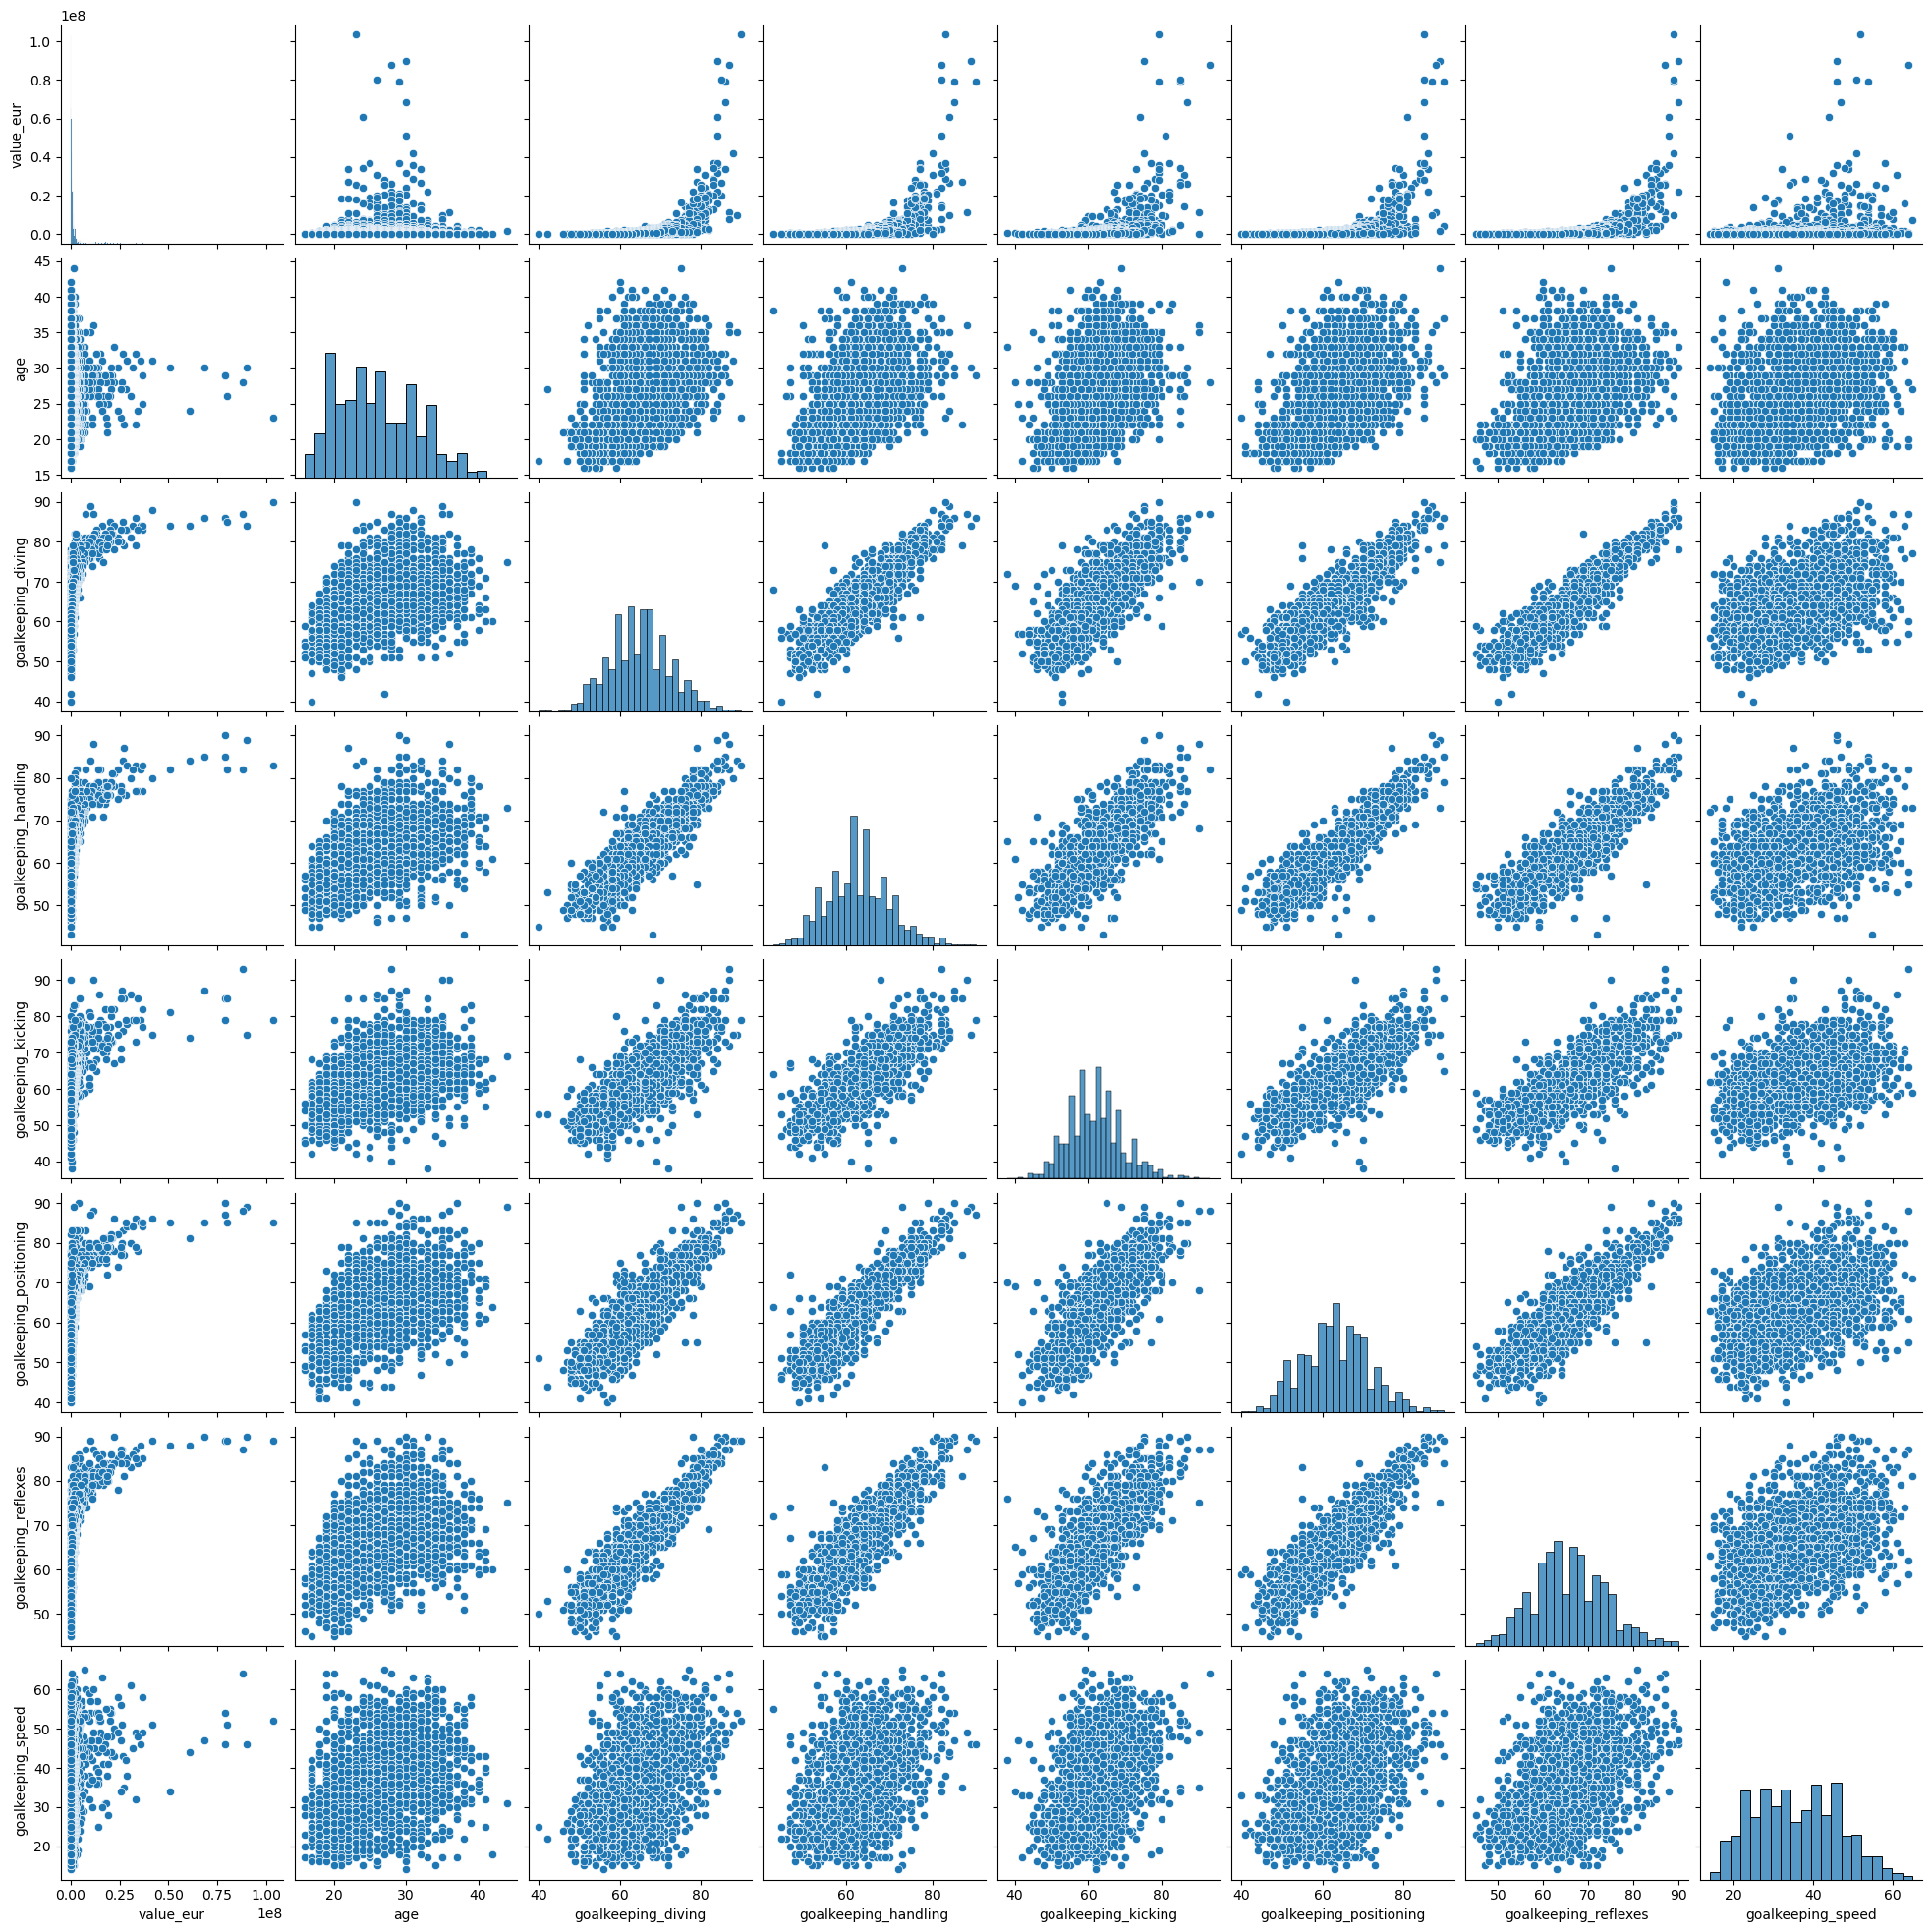

In [97]:
# Seaborn Scatter plots GK
sns.pairplot(model_data_goalkeepers)
plt.title('Goalkeepers Scatter Plots')
plt.show()

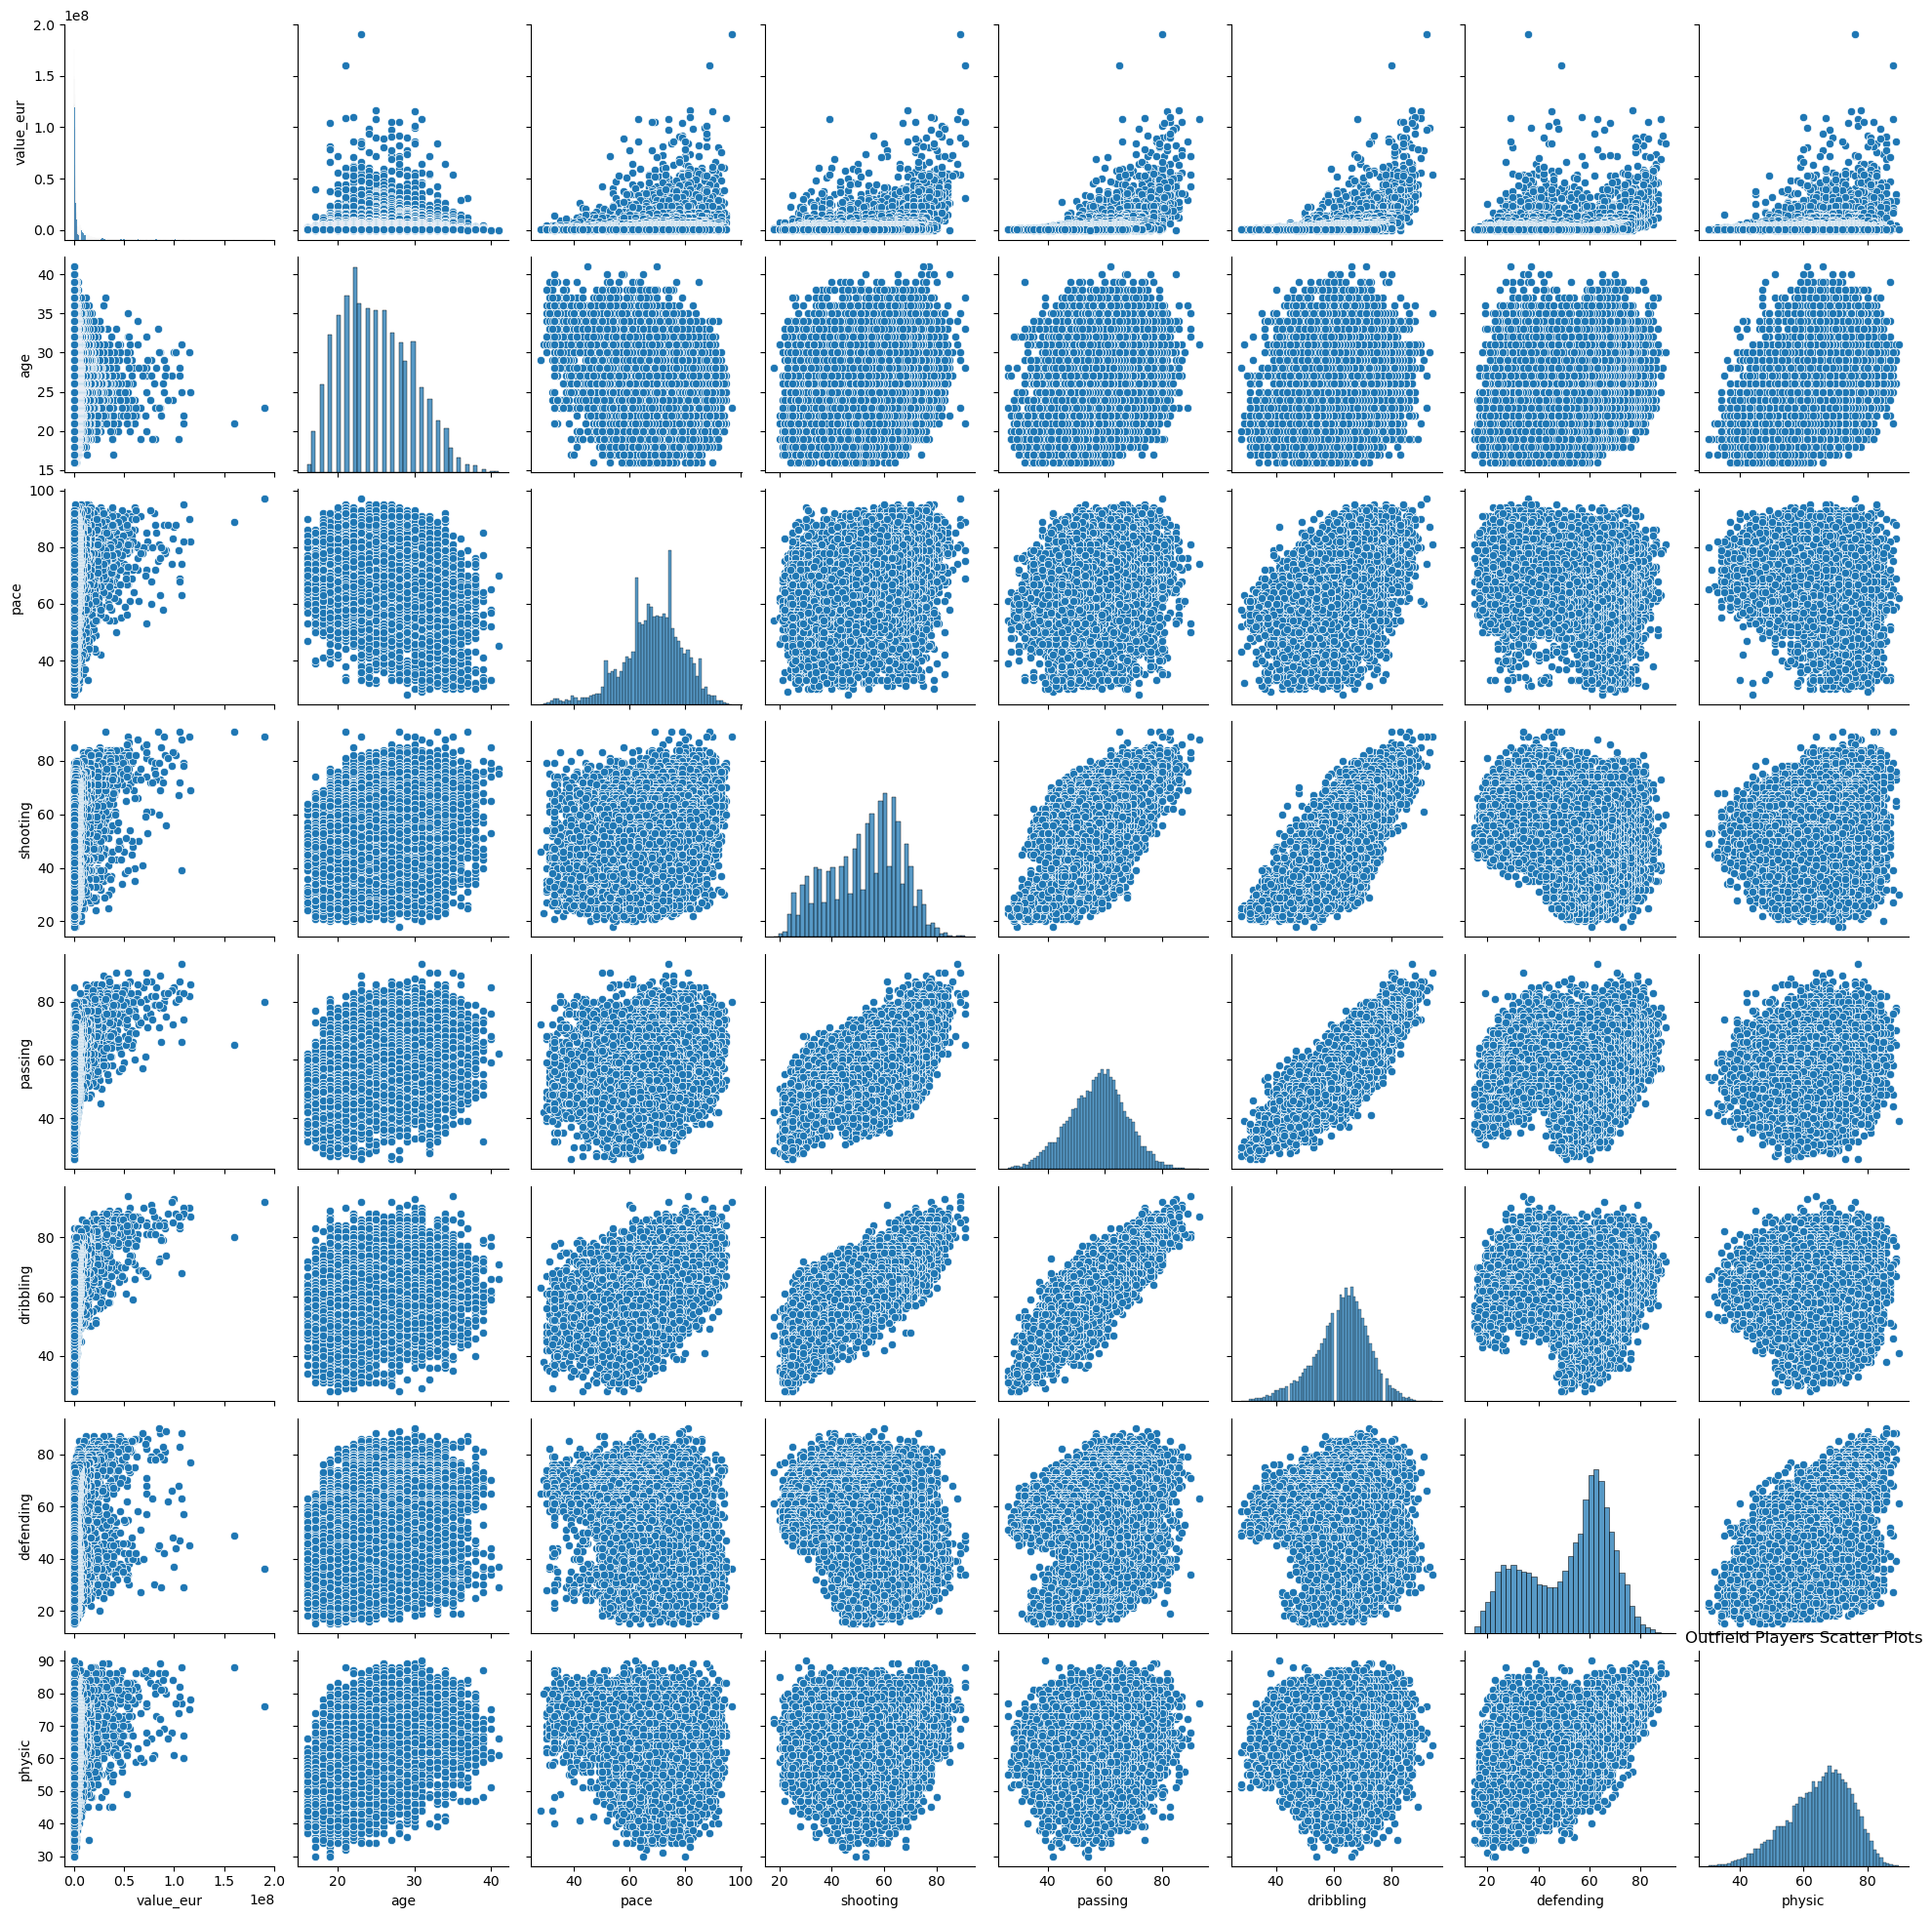

In [104]:
# Seaborn Scatter plots Outfield Players
sns.pairplot(model_data_outfieldplayers)
plt.show()

There is some linear relationship between player value and their attributes.

Highly correlated features:
{('goalkeeping_positioning', 'goalkeeping_reflexes'), ('goalkeeping_handling', 'goalkeeping_positioning'), ('goalkeeping_diving', 'goalkeeping_reflexes'), ('goalkeeping_handling', 'goalkeeping_reflexes'), ('goalkeeping_diving', 'goalkeeping_handling'), ('goalkeeping_diving', 'goalkeeping_positioning')}


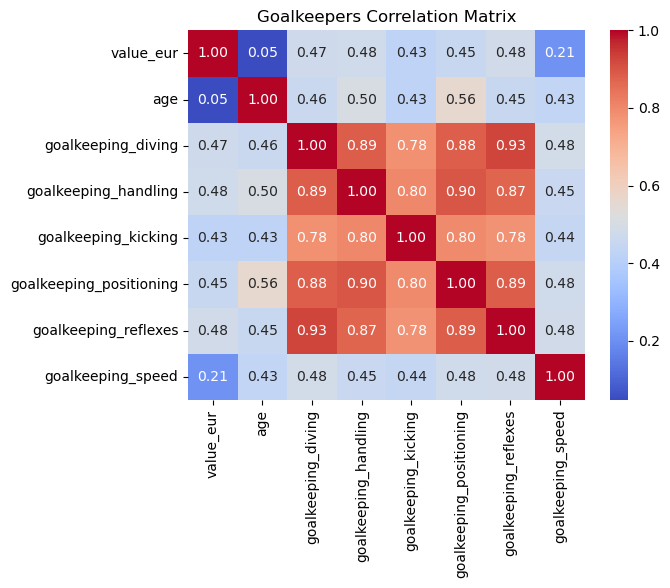

In [102]:
# GK Correlation matrix
# Plus checking for collinearity between features

corr_matrix_gk = model_data_goalkeepers.corr()

# plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix_gk, mask=False, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Goalkeepers Correlation Matrix')

# check for highly correlated features (threshold is 0.8)
highly_correlated = set()
for i in range(len(corr_matrix_gk.columns)):
    for j in range(i):
        if abs(corr_matrix_gk.iloc[i, j]) > 0.8:
            colname_i = corr_matrix_gk.columns[i]
            colname_j = corr_matrix_gk.columns[j]
            pair = tuple(sorted((colname_i, colname_j)))
            highly_correlated.add(pair)

print('Highly correlated features:')
print(highly_correlated)

Highly correlated features:
{('dribbling', 'passing')}


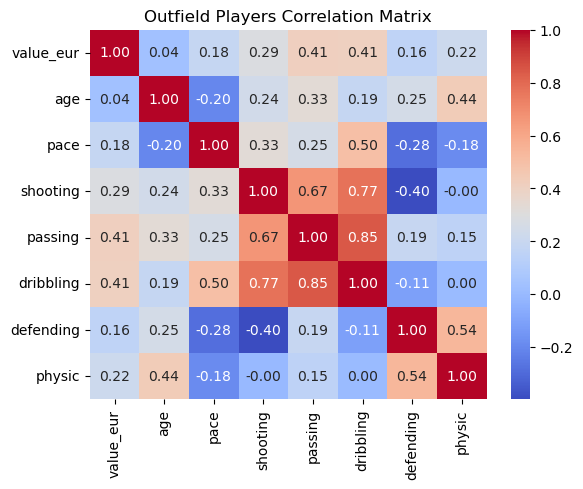

In [103]:
# Outfield players Correlation matrix
# Plus checking for collinearity between features

corr_matrix_op = model_data_outfieldplayers.corr()

# plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix_op, mask=False, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Outfield Players Correlation Matrix')

# check for highly correlated features (threshold is 0.8)
highly_correlated = set()
for i in range(len(corr_matrix_op.columns)):
    for j in range(i):
        if abs(corr_matrix_op.iloc[i, j]) > 0.8:
            colname_i = corr_matrix_op.columns[i]
            colname_j = corr_matrix_op.columns[j]
            pair = tuple(sorted((colname_i, colname_j)))
            highly_correlated.add(pair)

print('Highly correlated features:')
print(highly_correlated)

# Prediction Models

1. Linear Regression
2. Random Forest Regression
3. KNN Regression

## Linear Regression

### Baseline Metrics for Goalkeepers

In [105]:
X = model_data_goalkeepers.drop(['value_eur'], axis=1)
y = model_data_goalkeepers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

y_mean = y_train.mean()
# Use the mean value as prediction for each row
y_pred_baseline = [y_mean] * len(y_train)

print(f"Average Value: {y_mean:,.0f}")
print(f"Baseline RMSE: {sqrt(mean_squared_error(y_train, y_pred_baseline)):,.0f}")
print(f"Baseline MSE: {mean_squared_error(y_train, y_pred_baseline):,.0f}")
print(f"Baseline MAE: {mean_absolute_error(y_train, y_pred_baseline):,.0f}")
print(f"Baseline rSquared: {r2_score(y_train, y_pred_baseline):,.0f}")

Average Value: 1,943,313
Baseline RMSE: 6,835,008
Baseline MSE: 46,717,332,667,628
Baseline MAE: 2,351,811
Baseline rSquared: 0


### Baseline Metrics for Outfield Players

In [106]:
X = model_data_outfieldplayers.drop(['value_eur'], axis=1)
y = model_data_outfieldplayers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_mean = y_train.mean()
# Use the mean value as prediction for each row
y_pred_baseline = [y_mean] * len(y_train)

print(f"Average Value: {y_mean:,.0f}")
print(f"Baseline RMSE: {sqrt(mean_squared_error(y_train, y_pred_baseline)):,.0f}")
print(f"Baseline MSE: {mean_squared_error(y_train, y_pred_baseline):,.0f}")
print(f"Baseline MAE: {mean_absolute_error(y_train, y_pred_baseline):,.0f}")
print(f"Baseline rSquared: {r2_score(y_train, y_pred_baseline):,.0f}")

Average Value: 2,968,768
Baseline RMSE: 7,656,307
Baseline MSE: 58,619,042,852,009
Baseline MAE: 3,245,548
Baseline rSquared: 0


### Use the 6 base stats + Age for Linear Regression

In [107]:
# Graph for feature importance
def plotFeatureImportanceAsGraph(features,featureimportance, model):
    data={'feature_names':features,'feature_importance':featureimportance}
    df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(10,10))
    # Plot Searborn bar chart
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    # Add chart labels
    plt.title(model + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [108]:
# GK lr
X = model_data_goalkeepers.drop(['value_eur'], axis=1)
y = model_data_goalkeepers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

lr_gk_model = LinearRegression()
lr_gk_model.fit(X_train, y_train)

# Training Scores
y_predtrain = lr_gk_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = lr_gk_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 5,751,031
MSE: 33,074,358,034,834
MAE: 2,658,681
rSquared: 0.2920


Test Scores
RMSE: 3,635,714
MSE: 13,218,418,686,301
MAE: 2,544,015
rSquared: 0.3846


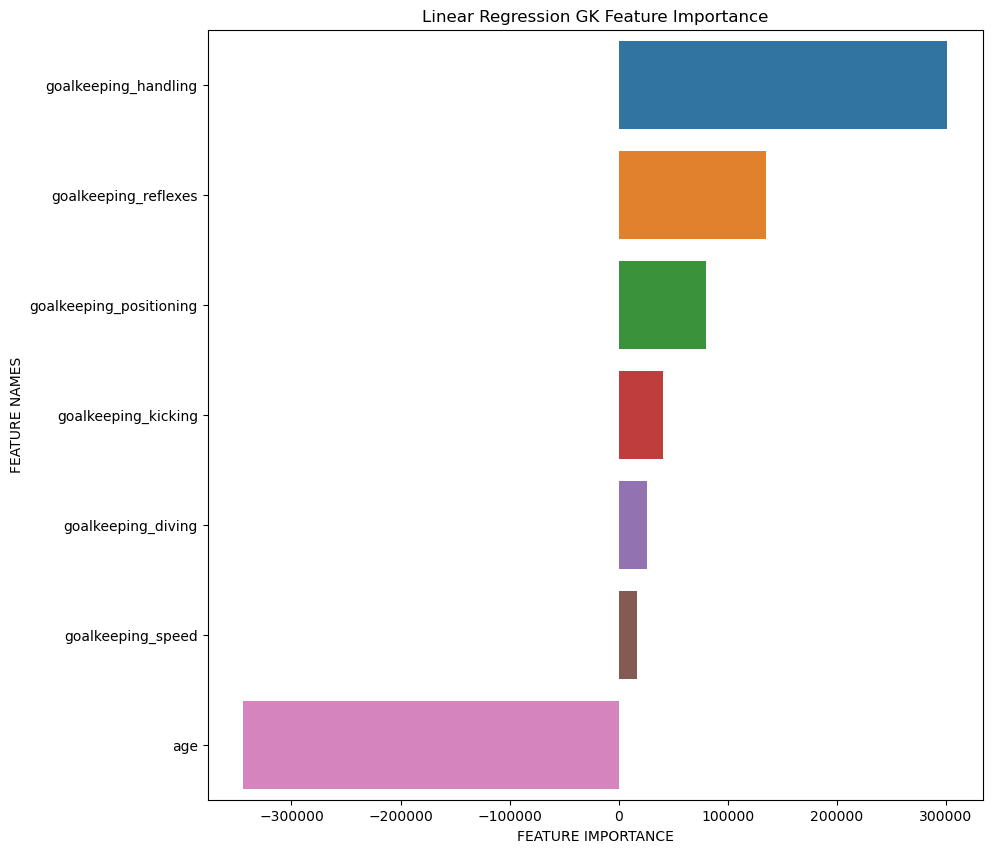

In [109]:
plotFeatureImportanceAsGraph(X.columns,lr_gk_model.coef_,"Linear Regression GK")

In [110]:
# Outfield Players lr
X = model_data_outfieldplayers.drop(['value_eur'], axis=1)
y = model_data_outfieldplayers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_op_model = LinearRegression()
lr_op_model.fit(X_train, y_train)

# Training Scores
y_predtrain = lr_op_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = lr_op_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 6,631,843
MSE: 43,981,337,003,950
MAE: 3,242,369
rSquared: 0.2497


Test Scores
RMSE: 6,960,746
MSE: 48,451,989,177,476
MAE: 3,345,977
rSquared: 0.2703


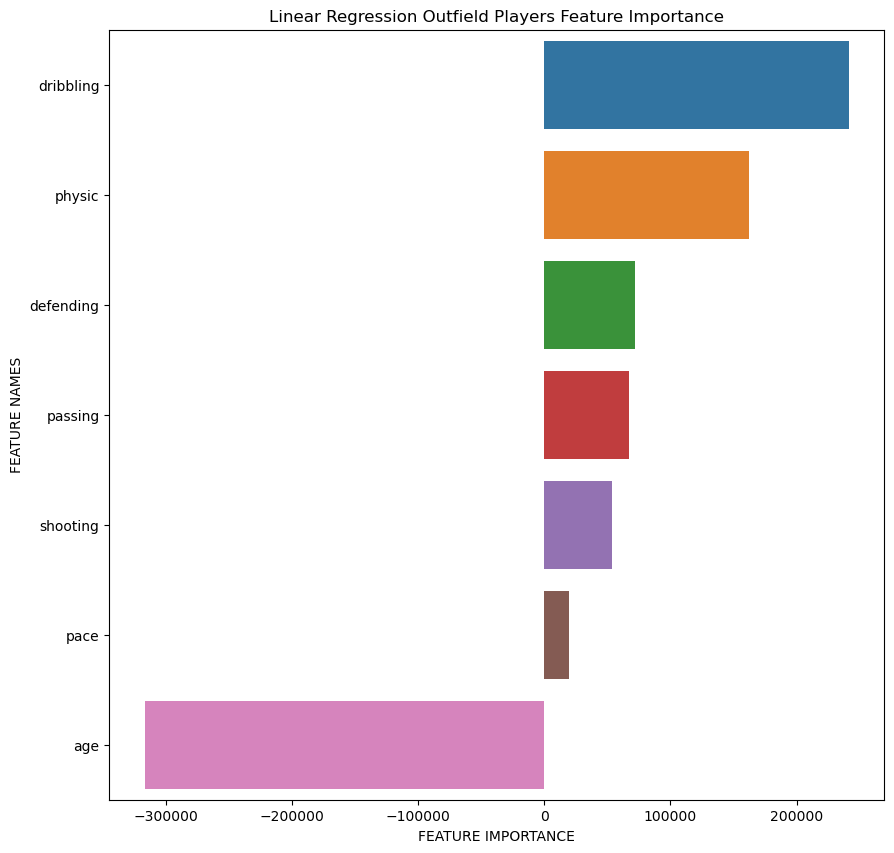

In [111]:
plotFeatureImportanceAsGraph(X.columns,lr_op_model.coef_,"Linear Regression Outfield Players")

### Standardise the dataset for Linear Regression

In [112]:
# Standardise GK data
target_df = model_data_goalkeepers[['value_eur']]
feature_df = model_data_goalkeepers.loc[:, ~model_data_goalkeepers.columns.isin(['value_eur'])]

scale = StandardScaler()
scaled_data = scale.fit_transform(feature_df)
feature_df_standard = pd.DataFrame(scaled_data, columns=feature_df.columns)
model_data_goalkeepers_standard = pd.concat([target_df,feature_df_standard], axis = 1)

In [113]:
# GK lr standardised
X = model_data_goalkeepers_standard.drop(['value_eur'], axis=1)
y = model_data_goalkeepers_standard['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

lr_gk_model = LinearRegression()
lr_gk_model.fit(X_train, y_train)

# Training Scores
y_predtrain = lr_gk_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = lr_gk_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 5,751,031
MSE: 33,074,358,034,834
MAE: 2,658,681
rSquared: 0.2920


Test Scores
RMSE: 3,635,714
MSE: 13,218,418,686,301
MAE: 2,544,015
rSquared: 0.3846


Standardisation does not affect the evaluation metrics.

In [114]:
# Standardise outfield players data
target_df = model_data_outfieldplayers[['value_eur']]
feature_df = model_data_outfieldplayers.loc[:, ~model_data_outfieldplayers.columns.isin(['value_eur'])]

scale = StandardScaler()
scaled_data = scale.fit_transform(feature_df)
feature_df_standard = pd.DataFrame(scaled_data, columns=feature_df.columns)
model_data_outfieldplayers_standard = pd.concat([target_df,feature_df_standard], axis = 1)

In [115]:
# Outfield players lr standardised
X = model_data_outfieldplayers_standard.drop(['value_eur'], axis=1)
y = model_data_outfieldplayers_standard['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_op_model = LinearRegression()
lr_op_model.fit(X_train, y_train)

# Training Scores
y_predtrain = lr_op_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = lr_op_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 6,631,843
MSE: 43,981,337,003,950
MAE: 3,242,369
rSquared: 0.2497


Test Scores
RMSE: 6,960,746
MSE: 48,451,989,177,476
MAE: 3,345,977
rSquared: 0.2703


Standardisation does not affect the evaluation metrics.

## Random Forest Regression

### Use the 6 base stats + Age for Random Forest Regression

In [120]:
# GK Random Forest Regression
X = model_data_goalkeepers.drop(['value_eur'], axis=1)
y = model_data_goalkeepers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
rf_gk_model = RandomForestRegressor(n_estimators=100, max_depth=None,
                                    min_samples_split=5, min_samples_leaf=5, random_state=42)

# Train the model on the training set
rf_gk_model.fit(X_train, y_train)

# Training Scores
y_predtrain = rf_gk_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = rf_gk_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 2,185,152
MSE: 4,774,888,677,322
MAE: 380,375
rSquared: 0.8978


Test Scores
RMSE: 1,267,514
MSE: 1,606,591,009,876
MAE: 368,720
rSquared: 0.9252


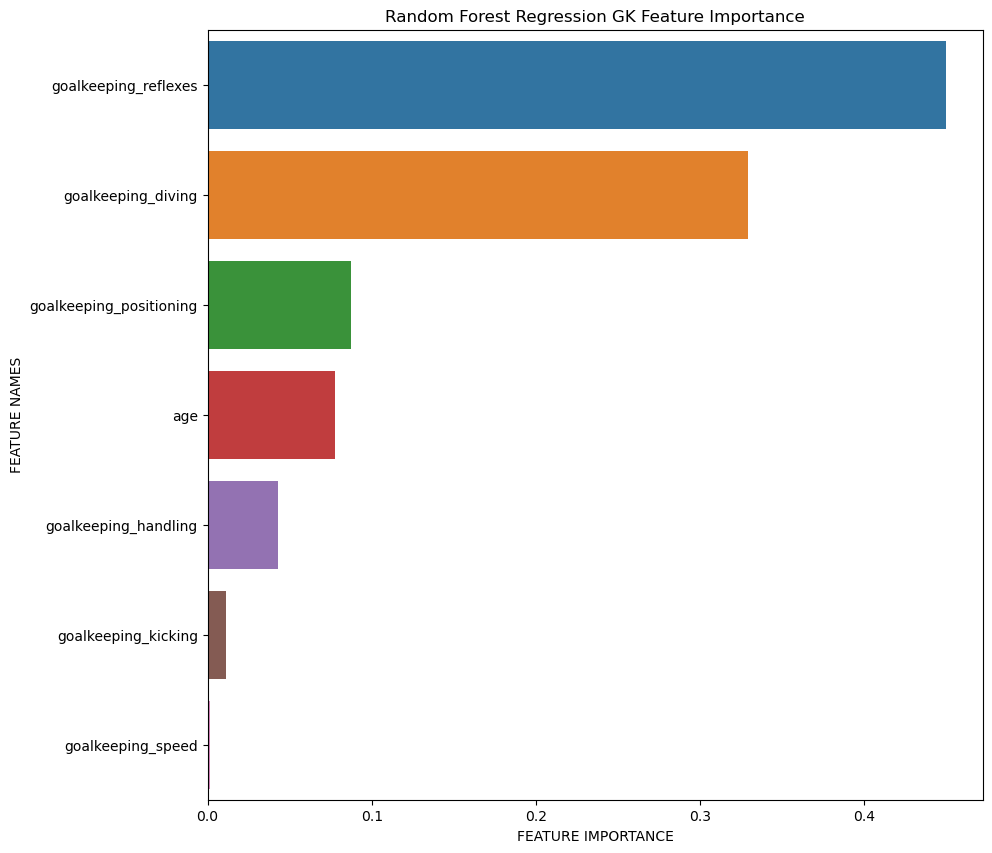

In [121]:
plotFeatureImportanceAsGraph(X.columns,rf_gk_model.feature_importances_,"Random Forest Regression GK")

In [123]:
# Outfield players Random Forest Regression
X = model_data_outfieldplayers.drop(['value_eur'], axis=1)
y = model_data_outfieldplayers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
rf_op_model = RandomForestRegressor(n_estimators=100, max_depth=None,
                                    min_samples_split=5, min_samples_leaf=5, random_state=42)

# Train the model on the training set
rf_op_model.fit(X_train, y_train)

# Training Scores
y_predtrain = rf_op_model.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = rf_op_model.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 2,318,582
MSE: 5,375,824,477,350
MAE: 580,886
rSquared: 0.9083


Test Scores
RMSE: 3,237,153
MSE: 10,479,157,121,920
MAE: 861,384
rSquared: 0.8422


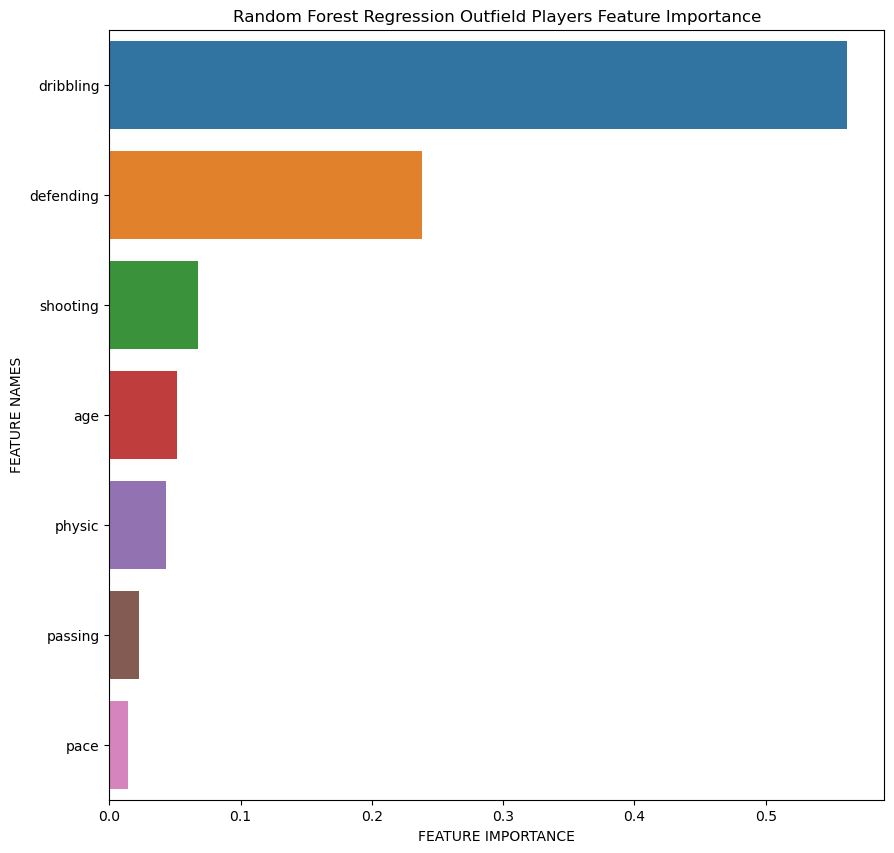

In [124]:
plotFeatureImportanceAsGraph(X.columns,rf_op_model.feature_importances_,"Random Forest Regression Outfield Players")

Random Forest Regression gives very good scores.

## KNN Regression

### Use the 6 base stats + Age for KNN Regression

In [125]:
# GK KNN Regression
X = model_data_goalkeepers.drop(['value_eur'], axis=1)
y = model_data_goalkeepers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNN regressor with k=3
knn_gk = KNeighborsRegressor(n_neighbors=3)

# Fit the model to the training data
knn_gk.fit(X_train, y_train)

# Training Scores
y_predtrain = knn_gk.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = knn_gk.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 2,015,886
MSE: 4,063,795,994,959
MAE: 433,506
rSquared: 0.9130


Test Scores
RMSE: 1,560,343
MSE: 2,434,670,145,697
MAE: 466,025
rSquared: 0.8866


KNeighborsRegressor models do not inherently calculate feature importance values so we will not be plotting the feature importance graph.

In [126]:
# Outfield players KNN Regression
X = model_data_outfieldplayers.drop(['value_eur'], axis=1)
y = model_data_outfieldplayers['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNN regressor with k=3
knn_op = KNeighborsRegressor(n_neighbors=3)

# Fit the model to the training data
knn_op.fit(X_train, y_train)

# Training Scores
y_predtrain = knn_op.predict(X_train)

trainrmse = sqrt(mean_squared_error(y_train, y_predtrain))
trainmse = mean_squared_error(y_train, y_predtrain)
trainmae = mean_absolute_error(y_train, y_predtrain)
trainrSquared = r2_score(y_train, y_predtrain)

print('Train Scores')
print(f'RMSE: {trainrmse:,.0f}')
print(f'MSE: {trainmse:,.0f}')
print(f'MAE: {trainmae:,.0f}')
print(f'rSquared: {trainrSquared:,.4f}')

# Testing Scores
y_predtest = knn_op.predict(X_test)

testrmse = sqrt(mean_squared_error(y_test, y_predtest))
testmse = mean_squared_error(y_test, y_predtest)
testmae = mean_absolute_error(y_test, y_predtest)
testrSquared = r2_score(y_test, y_predtest)

print('\n')
print('Test Scores')
print(f'RMSE: {testrmse:,.0f}')
print(f'MSE: {testmse:,.0f}')
print(f'MAE: {testmae:,.0f}')
print(f'rSquared: {testrSquared:,.4f}')

Train Scores
RMSE: 2,475,659
MSE: 6,128,887,994,259
MAE: 717,381
rSquared: 0.8954


Test Scores
RMSE: 4,005,950
MSE: 16,047,638,750,777
MAE: 1,073,331
rSquared: 0.7583


# Determine if players are overvalued / undervalued / fairly valued

## Use Random Forest Regression as it has the best performance

In [127]:
# Create column for predictions
# GK
X = model_data_goalkeepers.drop(['value_eur'], axis=1)
goalkeepers['Predicted Value'] = rf_gk_model.predict(X)

# Outfield players
X = model_data_outfieldplayers.drop(['value_eur'], axis=1)
outfieldplayers['Predicted Value'] = rf_op_model.predict(X)

In [128]:
# Create column for difference between actual and predicted value
# GK
goalkeepers['Over/Under Value'] = goalkeepers['value_eur'] - goalkeepers['Predicted Value']

# Outfield players
outfieldplayers['Over/Under Value'] = outfieldplayers['value_eur'] - outfieldplayers['Predicted Value']

In [129]:
# Create column for overvalued / undervalued / fair value labels
# GK
goalkeepers['Overvalued/Undervalued'] = np.where(goalkeepers['Over/Under Value']>0, 'Overvalued',
                                                 np.where(goalkeepers['Over/Under Value']==0, 'Fair value', 'Undervalued'))

# Outfield players
outfieldplayers['Overvalued/Undervalued'] = np.where(outfieldplayers['Over/Under Value']>0, 'Overvalued',
                                             np.where(outfieldplayers['Over/Under Value']==0, 'Fair value', 'Undervalued'))

In [130]:
# Concatenate GK and Outfield players datasets
players_final = pd.concat([goalkeepers,outfieldplayers],axis=0)
players_final.sort_values(by=['overall','potential'], ascending=False, inplace=True)
players_final.reset_index(drop=True, inplace=True)

In [133]:
players_final.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,Predicted Value,Over/Under Value,Overvalued/Undervalued
0,231747,/player/231747/kylian-mbappe/230009,23,9,13-01-23,K. Mbappe,Kylian Mbappe Lottin,"ST, LW",91,95,190500000.0,230000.0,23,20-12-98,182,73,16.0,Ligue 1,1.0,73.0,Paris Saint Germain,LS,7.0,NaN,01-07-18,2024.0,18,France,1335.0,LW,10.0,Right,4,5,4,High/Low,Unique,Yes,366700000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical Fin...","Solid Player, Flair, Speed Dribbler (AI), Outs...",97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88,26,34,32,13,5,7,11,6,NaN,89+3,89+3,89+3,90,90,90,90,90,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,67+3,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3,https://cdn.sofifa.net/players/231/747/23_120.png,9.446601e+07,9.603399e+07,Overvalued
1,158023,/player/158023/lionel-messi/230009,23,9,13-01-23,L. Messi,Lionel Andres Messi Cuccittini,RW,91,91,54000000.0,195000.0,35,24-06-87,169,67,16.0,Ligue 1,1.0,73.0,Paris Saint Germain,RS,30.0,NaN,10-08-21,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,99900000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,6,11,15,14,8,NaN,87+3,87+3,87+3,90,91,91,91,90,92-1,92-1,92-1,89+2,85+3,85+3,85+3,89+2,64+3,63+3,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3,https://cdn.sofifa.net/players/158/023/23_120.png,8.066656e+07,-2.666656e+07,Undervalued
2,165153,/player/165153/karim-benzema/230009,23,9,13-01-23,K. Benzema,Karim Benzema,"CF, ST",91,91,64000000.0,450000.0,34,19-12-87,185,81,53.0,La Liga,1.0,243.0,Real Madrid,CF,9.0,NaN,09-07-09,2023.0,18,France,NaN,NaN,NaN,Right,4,4,4,Medium/Medium,Normal (170-185),Yes,131200000.0,"#Poacher, #Clinical Finisher","Leadership, Finesse Shot, Playmaker (AI), Outs...",80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,13,11,5,5,7,NaN,89+2,89+2,89+2,87,89,89,89,87,88+3,88+3,88+3,86+3,81+3,81+3,81+3,86+3,64+3,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,https://cdn.sofifa.net/players/165/153/23_120.png,6.789264e+07,-3.892636e+06,Undervalued
3,188545,/player/188545/robert-lewandowski/230009,23,9,13-01-23,R. Lewandowski,Robert Lewandowski,ST,91,91,84000000.0,420000.0,33,21-08-88,185,81,53.0,La Liga,1.0,241.0,FC Barcelona,ST,9.0,NaN,18-07-22,2025.0,37,Poland,1353.0,ST,9.0,Right,4,4,5,High/Medium,Unique,Yes,172200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside F

In [135]:
# Filter out the columns we want
players_final = players_final[['player_id','player_url','short_name','long_name','player_positions',
                               'overall','potential','value_eur','wage_eur','age','league_name','club_name',
                               'nationality_name','pace','shooting','passing','dribbling','defending','physic',
                               'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
                               'goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed',
                               'player_face_url','Predicted Value','Over/Under Value','Overvalued/Undervalued'
                              ]].copy()

In [136]:
players_final.shape

(18127, 29)

In [137]:
# Export data to visualise in Tableau
# players_final.to_csv('Players.csv', index=False)